In [1]:
#coding=utf-8
%matplotlib inline
import sys
sys.path.insert(0, '../')

from AircraftIden.StateSpaceIden import StateSpaceIdenSIMO, StateSpaceParamModel

from AircraftIden import FreqIdenSIMO, TransferFunctionFit
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import sympy as sp
pkl_name = "../../../FLYLOG/foam-tail-sitter/cruising/log_34_2018-4-10-freq-res.pkl"
finput = open(pkl_name, 'rb')
freq_responses = pickle.load(finput)
def plot_freqres_for_status(freqres , key = "-"):
    
    plt.figure("ele_q")
    freqres.plt_bode_plot(0, label=key)
    plt.figure("ele_body_vx")
    freqres.plt_bode_plot(1, label=key)
    plt.figure("ele_body_vz")
    freqres.plt_bode_plot(2, label=key)
    plt.figure("ele_body_ax")
    freqres.plt_bode_plot(3, label=key)
    plt.figure("ele_body_az")
    freqres.plt_bode_plot(4, label=key)
    plt.show()

..\AircraftIden\FreqIden.py:158: RuntimeWarning: invalid value encountered in log10
  plt.semilogx(freq, 20 * np.log10(gxx), label=label+'gxx')


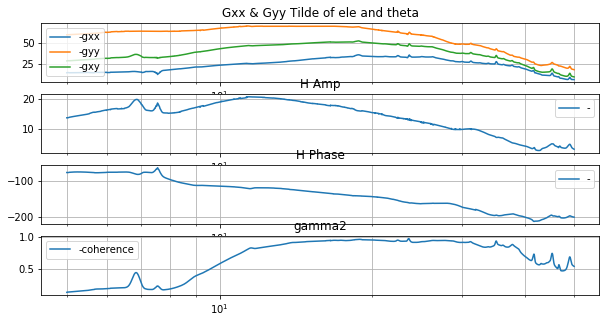

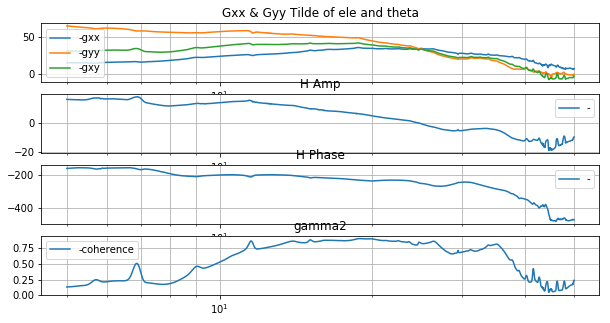

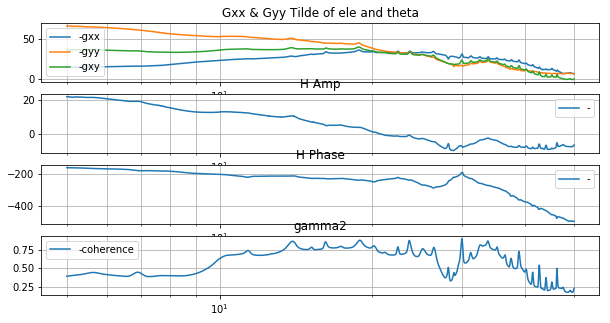

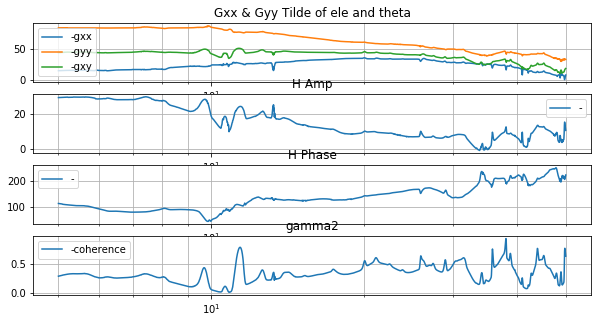

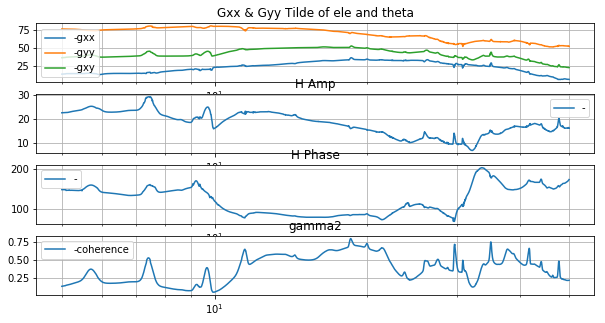

In [2]:
plt.rc('figure', figsize=(10.0, 5.0))
plt.close('all')
freqres_10ms = freq_responses["10m/s"]
plot_freqres_for_status(freqres_10ms)

In [3]:
# X = [u,w,q,th]
# Y = [u,w,q]

M = sp.Matrix([[1, 0, 0, 0],
               [0, 1 , 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])

# Tailsittel
#    0---Vx, W
#--- | ----
# |  |  |
#    |
#  Vz ,-U
# 10m/s 

# Vz trim is -6.05,Vz is negative U
# Vx trim is 4.55, Vx is W
g = 9.78
U0 = 6.05
W0 = 4.55
#Th0 in multi mode is -0.95
th0 = 1.57 - 0.95

print("Trim theta {:3.2f} U0 {:4.2f} W0 {:4.2f}".format(th0*180/3.1415, U0, W0))
Xu, Xw, Xq = sp.symbols('Xu Xw Xq')
Zu, Zw, Zq = sp.symbols('Zu Zw Zq')
Mu, Mw, Mq = sp.symbols('Mu Mw Mq')

F = sp.Matrix([[Xu, Xw, Xq - W0, -g * sp.cos(th0)],
               [Zu, Zw, Zq + U0, -g * sp.sin(th0)],
               [Mu, Mw, Mq, 0],
               [0, 0, 1, 0]])

Xele, Zele, Mele = sp.symbols('Xele,Zele,Mele')
G = sp.Matrix([[Xele],
               [Zele],
               [Mele],
               [0]])

# direct using -u w q for y
#U equal to negative u
H0 = sp.Matrix([
    [-1, 0, 0, 0],
    [0, 1, 0, 0],    
    [0, 0, 1, 0]]
)

H1 = sp.Matrix([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])

syms = [
        Xu, Xw, Xq,
        Zu, Zw, Zq,
        Mu, Mw, Mq,
        Xele, Zele, Mele
]
LatdynSSPM = StateSpaceParamModel(M, F, G, H0, H1, syms)

Trim theta 35.52 U0 6.05 W0 4.55


Will estimate num 12 [A_0_0, A_0_1, A_0_2, A_1_0, A_1_1, A_1_2, A_2_0, A_2_1, A_2_2, B_0_0, B_1_0, B_2_0]
Found new better 148.82598107871888
Terminate pool
Eigs [-6.05884492e+00+9.88559671j -6.05884492e+00-9.88559671j
  4.82011646e-07+1.82188265j  4.82011646e-07-1.82188265j]
Stable
{Xu: -0.735067404313389, Xw: 2.43685706922338, Xq: 1.51433046680308, Zu: -2.14193890889302, Zw: -9.15493819679615, Zq: -4.15239907803423, Mu: -3.89728622719574, Mw: -60.9210529218740, Mq: -2.22768327794732, Xele: 10.6003144931169, Zele: -32.8197311946041, Mele: -18.3595801473834}
A
[[ -0.7350674    2.43685707  -3.03566953  -7.95973131]
 [ -2.14193891  -9.1549382    1.89760092  -5.68252387]
 [ -3.89728623 -60.92105292  -2.22768328   0.        ]
 [  0.           0.           1.           0.        ]]
B
[[ 10.60031449]
 [-32.81973119]
 [-18.35958015]
 [  0.        ]]


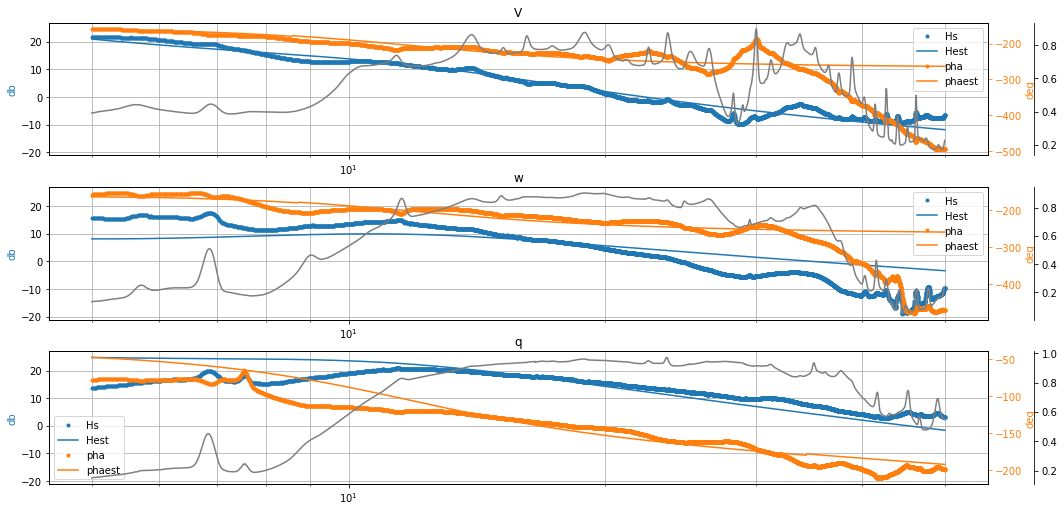

In [5]:
plt.rc('figure', figsize=(10.0, 5.0))
freqres = freqres_10ms.get_freqres(indexs = [2,1,0])
ssm_iden = StateSpaceIdenSIMO(freqres, accept_J=150,
                              enable_debug_plot=False,
                              y_names=["V", "w", "q"],reg=1.0 )
J, ssm = ssm_iden.estimate(LatdynSSPM, syms, constant_defines={})
ssm.check_stable()
ssm_iden.draw_freq_res()
ssm_iden.print_res()